### Standard LSTM based transformer model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Add, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular

/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable eager execution
tf.compat.v1.enable_eager_execution()

In [3]:
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

# Define features and target variable
FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
            'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
            'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
            'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
            'active_power_rolling_mean', 'active_power_rolling_std']
TARGET = 'active_power'

In [4]:
# Extract feature and target values
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

# Apply MinMax scaling
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Create Sequential Data for Transformer
time_steps = 3
features_dim = X_scaled.shape[1]

# Each sample becomes a sequence of the previous 'time_steps' rows
X_seq = np.array([X_scaled[i-time_steps:i] for i in range(time_steps, len(X_scaled))])
y_seq = y_scaled[time_steps:]

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Build Transformer Model with Fixed Hyperparameters
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([inputs, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    
    # Second skip connection and normalization
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer_model():
    inputs = Input(shape=(time_steps, features_dim))
    x = inputs
    
    # Use 2 transformer layers with fixed hyperparameters:
    num_layers = 2
    for i in range(num_layers):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    
    # Convert the sequence to a fixed-length vector via global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Optional Dense layer with dropout
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse', metrics=['mae', 'mape'])
    return model


In [7]:
# Build and display model summary
model_transformer = build_transformer_model()
model_transformer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 21)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 21)     │     22,293 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3, 21)     │          0 │ input_layer[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 3, 21)     │         42 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3, 128)    │      2,816 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3, 21)     │      2,709 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3, 21)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 21)     │     22,293 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3, 128)    │      2,816 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3, 21)     │      2,709 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 3, 21)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 3, 21)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 21)     │         42 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 21)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,816 │ global_average_p

 Total params: 58,749 (229.49 KB)

 Trainable params: 58,749 (229.49 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train Transformer Model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

history = model_transformer.fit(
    X_train, y_train,
    epochs=5000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# history = model_transformer.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_val, y_val),
#     verbose=1
# )

Epoch 1/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - loss: 0.0088 - mae: 0.0491 - mape: 140.2756 - val_loss: 0.0015 - val_mae: 0.0164 - val_mape: 27.0841 - learning_rate: 1.0000e-04
Epoch 2/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.0015 - mae: 0.0187 - mape: 88.2006 - val_loss: 0.0014 - val_mae: 0.0151 - val_mape: 24.6592 - learning_rate: 1.0000e-04
Epoch 3/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0015 - mae: 0.0175 - mape: 47.1368 - val_loss: 0.0014 - val_mae: 0.0142 - val_mape: 21.1924 - learning_rate: 1.0000e-04
Epoch 4/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - loss: 0.0014 - mae: 0.0168 - mape: 125.4797 - val_loss: 0.0014 - val_mae: 0.0164 - val_mape: 32.3469 - learning_rate: 1.0000e-04
Epoch 5/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - loss: 0.0014 - mae: 0.0166 - mape: 34.2378 - val_loss: 0.0013 - val_mae: 0.0137 - val_mape: 23.0345 - learning_rate: 1.0000e-04
Epoch 6/5000
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms

In [9]:
# Evaluate Model Performance
loss = model_transformer.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Generate predictions and convert back to original scale
y_pred = model_transformer.predict(X_test)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute evaluation metrics
mse_val = mean_squared_error(y_test_original, y_pred_original)
mae_val = mean_absolute_error(y_test_original, y_pred_original)
r2_val = r2_score(y_test_original, y_pred_original)

print(f'Mean Squared Error (MSE): {mse_val}')
print(f'Mean Absolute Error (MAE): {mae_val}')
print(f'R-squared (R2): {r2_val}')

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0014 - mae: 0.0129 - mape: 20.0212
Test Loss: [0.001337461406365037, 0.012718291021883488, 20.13277816772461]
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Mean Squared Error (MSE): 0.0013374617986412604
Mean Absolute Error (MAE): 0.012718289339308141
R-squared (R2): 0.6980896079539163


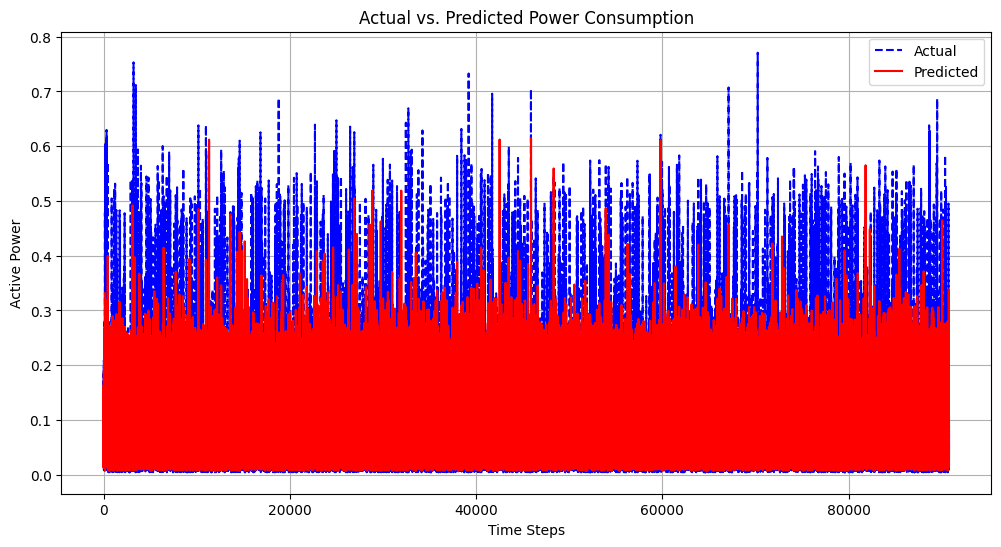

In [10]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Active Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid()
plt.show()

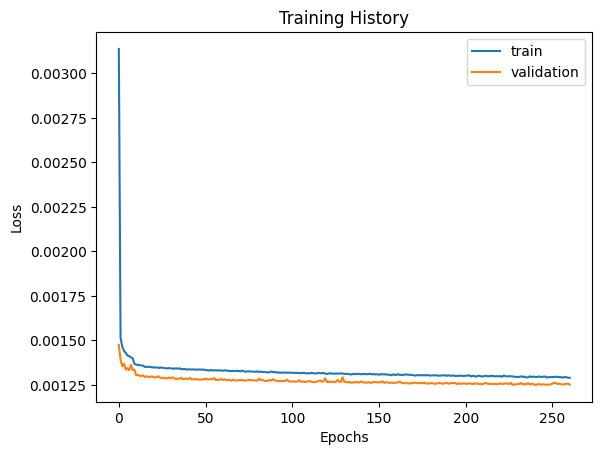

In [11]:
# Visualize training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()

In [13]:
features_dim = len(FEATURES)

In [15]:
# LIME Explanation for the LSTM Model

# Flatten the sequential data from (samples, time_steps, features) to (samples, time_steps*features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Generate feature names for flattened data: e.g., current_t1, voltage_t1, ...
feature_names_flat = []
for t in range(time_steps):
    for feature in FEATURES:
        feature_names_flat.append(f"{feature}_t{t+1}")

# Define a wrapper function that reshapes the flat data back to the sequential shape before predicting
def predict_wrapper(flat_data):
    n_samples = flat_data.shape[0]
    reshaped = flat_data.reshape(n_samples, time_steps, features_dim)  # Use features_dim instead of FEATURES
    preds = model_transformer.predict(reshaped)
    return preds.ravel()  # Return a 1D array

# Create a LimeTabularExplainer for regression
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

# Explain the prediction for one test instance (using the first instance as an example)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10  # Adjust to show top contributing features
)

# Display the LIME explanation
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except ImportError:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))

# Alternatively, print the explanation as text in the console
print("LIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


LIME Explanation (Feature Contributions):
apparent_power_t1 <= 0.06: -0.0235
apparent_power_t2 <= 0.06: -0.0232
apparent_power_t3 <= 0.06: -0.0230
current_t2 <= 0.05: -0.0187
current_t3 <= 0.05: -0.0181
current_t1 <= 0.05: -0.0169
active_power_lag_1_t3 <= 0.05: 0.0163
active_power_lag_1_t1 <= 0.05: 0.0135
active_power_lag_1_t2 <= 0.05: 0.0135
year_t2 <= 0.50: -0.0108


In [16]:
# Save Lime explanation as HTML
lime_html = exp.as_html()   
with open('exp14_lime_explanation.html', 'w') as f:
    f.write(lime_html)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 10%|█         | 1/10 [00:11<01:40, 11.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 20%|██        | 2/10 [00:21<01:23, 10.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 30%|███       | 3/10 [00:31<01:12, 10.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 40%|████      | 4/10 [00:40<00:59,  9.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 50%|█████     | 5/10 [00:49<00:47,  9.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 60%|██████    | 6/10 [00:58<00:37,  9.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 70%|███████   | 7/10 [01:07<00:27,  9.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 80%|████████  | 8/10 [01:16<00:18,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 90%|█████████ | 9/10 [01:25<00:09,  9.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


100%|██████████| 10/10 [01:34<00:00,  9.48s/it]


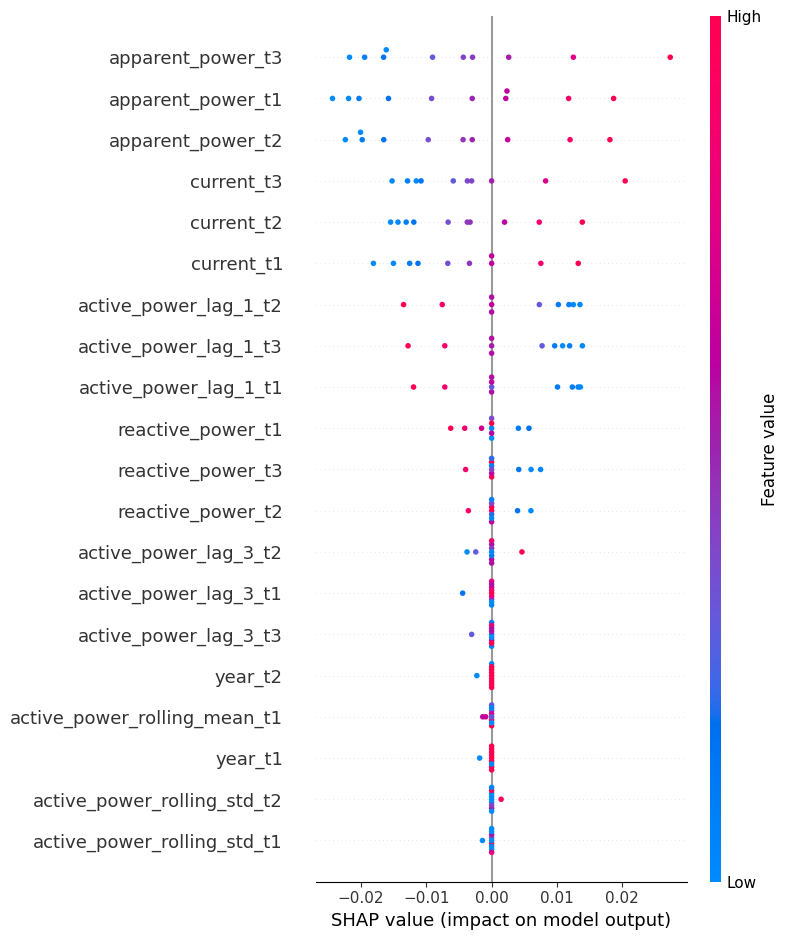

In [17]:
# Define a prediction wrapper
def predict_shap(data):
    # Reshape the flat data back to the original shape (samples, time_steps, features)
    reshaped_data = data.reshape(data.shape[0], time_steps, features_dim)
    return model_transformer.predict(reshaped_data).flatten()

# Use a subset of X_train for the explainer
explainer = shap.KernelExplainer(predict_shap, X_train[:100].reshape(100, -1))  # Flatten for KernelExplainer

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test[:10].reshape(10, -1))  # Flatten for KernelExplainer

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test[:10].reshape(10, -1), feature_names=feature_names_flat)